In [32]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

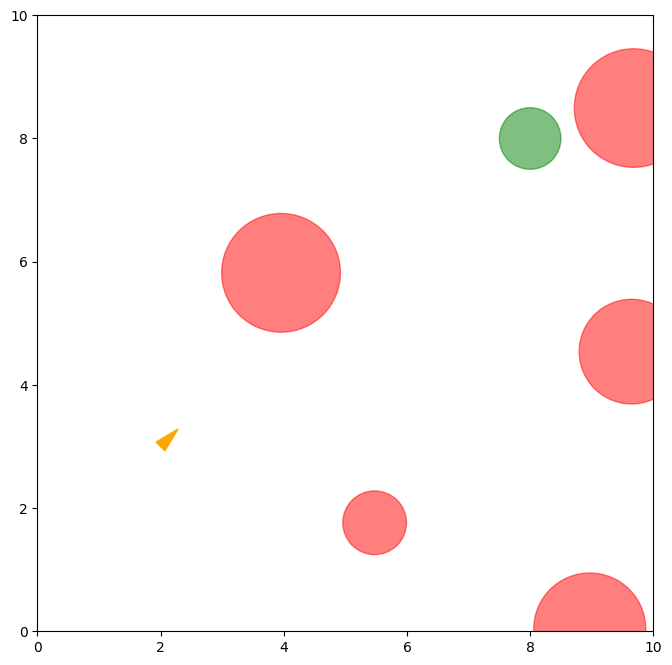

In [ ]:
# Define the environment size
ENV_SIZE = 10
DYNAMIC_OBSTACLES_FLAG = True

class Obstacle:
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
        self.mass = np.pi * r**2  # assuming uniform density
        
        self.vx = np.random.uniform(-3, 3) if DYNAMIC_OBSTACLES_FLAG else 0.
        self.vy = np.random.uniform(-3, 3) if DYNAMIC_OBSTACLES_FLAG else 0.

    def move(self, dt=0.1):
        self.x += self.vx * dt
        self.y += self.vy * dt
        # Reflect off walls
        if self.x - self.r < 0 or self.x + self.r > ENV_SIZE:
            self.vx *= -1
        if self.y - self.r < 0 or self.y + self.r > ENV_SIZE:
            self.vy *= -1

    def draw(self, ax):
        self.circle = plt.Circle((self.x, self.y), self.r, color='red', alpha=0.5)
        ax.add_patch(self.circle)
        return self.circle

    def update_patch(self):
        self.circle.center = (self.x, self.y)
        return [self.circle]
    
    def resolve_collision(self, obstacle, restitution=0.8):
        dx, dy = obstacle.x - self.x, obstacle.y - self.y
        dist = np.hypot(dx, dy)
        min_dist = self.r + obstacle.r

        if dist == 0 or dist >= min_dist:
            return  # no collision
        
        if dist < 1e-6: # Add a small epsilon to avoid near-zero division
             nx, ny = 0, 0 # Effectively no normal if too close to avoid instability
        else:
            nx, ny = dx / dist, dy / dist
        # Normalize vector

        # Resolve penetration: push obstacles apart
        overlap = min_dist - dist
        correction = 0.5 * overlap  # push each by half the overlap
        self.x -= correction * nx
        self.y -= correction * ny
        obstacle.x += correction * nx
        obstacle.y += correction * ny

        # Relative velocity
        dvx = self.vx - obstacle.vx
        dvy = self.vy - obstacle.vy
        rel_vel = dvx * nx + dvy * ny

        if rel_vel > 0:
            return  # already moving apart after position correction

        # Elastic collision with restitution (1 = perfectly elastic)
        impulse = -(1 + restitution) * rel_vel / (self.mass + obstacle.mass)
        self.vx += impulse * nx / self.mass
        self.vy += impulse * ny / self.mass
        obstacle.vx -= impulse * nx * obstacle.mass
        obstacle.vy -= impulse * ny * obstacle.mass

# Unicycle model parameters
class Unicycle:
    def __init__(self, x=0.0, y=0.0, theta=0.0, length=0.4, width=0.2):
        """
        initialize unicycle state and geometry
        """
        self.length = length
        self.width = width
        self.set_state(x, y, theta)

    
    def set_state(self, x, y, theta):
        """
        Updating the state of the unicycle car

        """
        self.x = x
        self.y = y
        self.theta = theta  # heading angle in radians
        
        # components of along x and y
        self.dx = self.length * np.cos(self.theta)
        self.dy = self.length * np.sin(self.theta)
        self.center = ((self.x + self.dx) / 2, (self.y + self.dy) / 2)
        self.build_geometry()
        

    def build_geometry(self):
        """
        Building the geometry for the car. In this case a triangle
        """
        # finding the rear coordinates of the triangle
        left = (self.x - 0.5 * self.width * np.sin(self.theta), self.y + 0.5 * self.width * np.cos(self.theta))
        right = (self.x + 0.5 * self.width * np.sin(self.theta), self.y - 0.5 * self.width * np.cos(self.theta))

        # tip coorindate is the origin + the components
        tip = (self.center[0] * 2.0, self.center[1] * 2.0)

        # last coordinate has to match the first one in order to  complete the outline
        self.geometry = np.array([left, right, tip, left])


    def draw_patch(self, ax):
        """
        plotting the geometry
        """
        self.patch = ax.fill(self.geometry[:, 0], self.geometry[:, 1], color='orange')[0]
        return self.patch

    def update_patch(self):            
        """
        updating the geometry
        """
        self.patch.set_xy(self.geometry)
        return [self.patch]
        


def generate_obstacles(num_obstacles, unicycle_center, tolerance_u, goal, max_attempts=100):
    """
    Generating random circular obstacles that do not interfere with the goal and the car
    """
    obstacles = []
    attempts = 0

    while len(obstacles) < num_obstacles and attempts < max_attempts:
        
        # Optionally adjust sampling region or bias if too many attempts
        if attempts > 0 and attempts % 100 == 0:
            print(f"[Info] Attempt #{attempts}, obstacles placed: {len(obstacles)}")

        x, y = np.random.uniform(0, ENV_SIZE, size=2)
        r = np.random.uniform(0.3, 1.0)

        # Check overlap with unicycle and goal
        dist_to_unicycle = np.hypot(x - unicycle_center[0], y - unicycle_center[1])
        dist_to_goal = np.hypot(x - goal[0], y - goal[1])

        if dist_to_unicycle < r + 10 * tolerance_u or dist_to_goal < r + goal[-1] + 0.2:
            attempts += 1
            continue

        # Check for overlap with existing obstacles
        overlaps = False
        for ob in obstacles:
            dist = np.hypot(x - ob.x, y - ob.y)
            if dist < r + ob.r + 0.2:  # Add buffer
                overlaps = True
                break

        # Create New Obstacle
        if not overlaps:
            obstacles.append(Obstacle(x, y, r))
        attempts += 1

    if attempts == max_attempts:
        print("[Warning] Max attempts reached. Could not place all obstacles without overlap.")

    return obstacles


def animate_sequence(unicycle, goal, obstacles, trajectory):
    """
    Animation
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, ENV_SIZE)
    ax.set_ylim(0, ENV_SIZE)
    ax.set_aspect('equal')
    ax.add_patch(plt.Circle(goal[:-1], radius=goal[-1], color='green', alpha=0.5, label="Goal"))
    obstacle_patches = [ob.draw(ax) for ob in obstacles]
    unicycle.draw_patch(ax)

    def update(frame):
        for ob in obstacles:
            ob.move()
        for i in range(len(obstacles)):
            for j in range(i + 1, len(obstacles)):
                obstacles[i].resolve_collision(obstacles[j])
        for ob in obstacles:
            ob.update_patch()
        x, y, theta = trajectory[frame]
        unicycle.set_state(x, y, theta)
        updated_patches = unicycle.update_patch()
        updated_patches.extend([ob.update_patch()[0] for ob in obstacles])
        return updated_patches
        
    ani = animation.FuncAnimation(fig, update, frames=len(trajectory), interval=200, blit=True, repeat=False)
    plt.show()
    return ani


# Example usage
unicycle = Unicycle(x=2.0, y=3.0, theta=np.pi/4)
goal = (8.0, 8.0, 0.5)
obstacles = generate_obstacles(num_obstacles=5, unicycle_center=unicycle.center, tolerance_u=max(unicycle.length, unicycle.width), goal=goal)

# Define a dummy trajectory for demo
trajectory = [(2.0 + i*0.2, 3.0 + i*0.2, np.pi/4 + i*0.05) for i in range(100)]
ani= animate_sequence(unicycle, goal, obstacles, trajectory)

In [34]:
HTML(ani.to_jshtml())

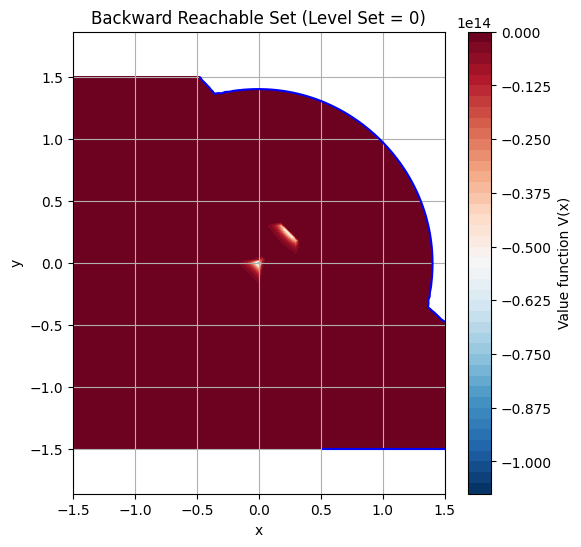

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Grid parameters
grid_min = -1.5
grid_max = 1.5
N = 101
x = np.linspace(grid_min, grid_max, N)
y = np.linspace(grid_min, grid_max, N)
X, Y = np.meshgrid(x, y)

# Goal set: circle of radius 0.4 around origin
goal_radius = 0.4
phi0 = np.sqrt(X**2 + Y**2) - goal_radius  # level-set function

# Parameters
dx = x[1] - x[0]
dy = y[1] - y[0]
dt = 0.01
T = 1.0
timesteps = int(T / dt)

# Dynamics: simple single integrator with control u in [-1, 1]^2
control_bound = 1.0

# Initialize value function
V = phi0.copy()

# Helper function: upwind gradients
def compute_gradients(V):
    dVdx_fwd = np.zeros_like(V)
    dVdx_bwd = np.zeros_like(V)
    dVdy_fwd = np.zeros_like(V)
    dVdy_bwd = np.zeros_like(V)

    dVdx_fwd[:, :-1] = (V[:, 1:] - V[:, :-1]) / dx
    dVdx_bwd[:, 1:] = (V[:, 1:] - V[:, :-1]) / dx

    dVdy_fwd[:-1, :] = (V[1:, :] - V[:-1, :]) / dy
    dVdy_bwd[1:, :] = (V[1:, :] - V[:-1, :]) / dy

    dVdx = np.where(V >= 0, dVdx_bwd, dVdx_fwd)
    dVdy = np.where(V >= 0, dVdy_bwd, dVdy_fwd)

    return dVdx, dVdy

# Time integration (backward in time)
for t in range(timesteps):
    dVdx, dVdy = compute_gradients(V)
    # Hamiltonian: min_u (grad V · f) = -control_bound * |grad V|
    grad_norm = np.sqrt(dVdx**2 + dVdy**2)
    H = -control_bound * grad_norm
    V = V + dt * H

# Plot the final reachable set
plt.figure(figsize=(6, 6))
contour = plt.contour(X, Y, V, levels=[0], colors='b')
plt.contourf(X, Y, V, levels=50, cmap='RdBu_r')
plt.colorbar(label='Value function V(x)')
plt.title("Backward Reachable Set (Level Set = 0)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.show()
